#### Инициализация Keras

torch был заменен на jax, так как с torch рекуррентные сети не работали

In [1]:
import os

os.environ["KERAS_BACKEND"] = "jax"
import keras

print(keras.__version__)

3.9.2


#### Загрузка данных для классификации с помощью глубоких сетей

В качестве набора данных используется набор отзывов к фильмам с сайта IMDB.

Набор включает 50 000 отзывов, половина из которых находится в обучающем наборе данных (x_train), а половина - в тестовом (x_valid). 

Метки (y_train и y_valid) имеют бинарный характер и назначены в соответствии с этими 10-балльными оценками:
- отзывы с четырьмя звездами или меньше считаются отрицательным (y = 0);
- отзывы с семью звездами или больше считаются положительными (y = 1);
- умеренные отзывы — с пятью или шестью звездами — не включались в набор данных, что упрощает задачу бинарной классификации.

Данные уже предобработаны для простоты работы с ними.

unique_words - в векторное пространство включается только слова, которые встречаются в корпусе не менее 10 000 раз.

max_length - максимальная длина отзыва (если больше, то обрезается, если меньше, то дополняется "пустыми" словами).

In [2]:
from keras.api.datasets import imdb
import os

unique_words = 10000
max_length = 100

output_dir = "tmp"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

(X_train, y_train), (X_valid, y_valid) = imdb.load_data(num_words=unique_words)

#### Приведение отзывов к длине max_length (100)

padding и truncating - дополнение и обрезка отзывов начинается с начала (учитывается специфика затухания градиента в рекуррентных сетях)

In [3]:
from keras.api.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train, maxlen=max_length, padding="pre", truncating="pre", value=0)
X_valid = pad_sequences(X_valid, maxlen=max_length, padding="pre", truncating="pre", value=0)

#### Формирование архитектуры глубокой рекуррентной сети


Первый слой (Embedding) выполняет векторизацию

In [4]:
from keras.api.models import Sequential
from keras.api.layers import InputLayer, Embedding, SpatialDropout1D, SimpleRNN, Dense

rnn_model = Sequential()
rnn_model.add(InputLayer(shape=(max_length,), dtype="float32"))
rnn_model.add(Embedding(unique_words, 64))
rnn_model.add(SpatialDropout1D(0.2))
rnn_model.add(SimpleRNN(256, dropout=0.2))
rnn_model.add(Dense(1, activation="sigmoid"))

rnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 100, 64)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 256)            │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 722,433 (2.76 MB)

 Trainable params: 722,433 (2.76 MB)

 Non-trainable params: 0 (0.00 B)

#### Обучение модели

Веса модели сохраняются в каталог tmp после каждой эпохи обучения с помощью callback-параметра

В дальнейшем веса можно загрузить

In [5]:
from keras.api.callbacks import ModelCheckpoint

rnn_model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"],
)

rnn_model.fit(
    X_train,
    y_train,
    batch_size=128,
    epochs=16,
    validation_data=(X_valid, y_valid),
    callbacks=[ModelCheckpoint(filepath=output_dir + "/rnn_weights.{epoch:02d}.keras")],
)

Epoch 1/16
196/196 ━━━━━━━━━━━━━━━━━━━━ 14s 68ms/step - accuracy: 0.5207 - loss: 0.6994 - val_accuracy: 0.5872 - val_loss: 0.6700
Epoch 2/16
196/196 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - accuracy: 0.6188 - loss: 0.6423 - val_accuracy: 0.6368 - val_loss: 0.6183
Epoch 3/16
196/196 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - accuracy: 0.7102 - loss: 0.5539 - val_accuracy: 0.6463 - val_loss: 0.6441
Epoch 4/16
196/196 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.7746 - loss: 0.4737 - val_accuracy: 0.7338 - val_loss: 0.5681
Epoch 5/16
196/196 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.8127 - loss: 0.4065 - val_accuracy: 0.6766 - val_loss: 0.6422
Epoch 6/16
196/196 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.8613 - loss: 0.3246 - val_accuracy: 0.7152 - val_loss: 0.6385
Epoch 7/16
196/196 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - accuracy: 0.8923 - loss: 0.2667 - val_accuracy: 0.7202 - val_loss: 0.6684
Epoch 8/16
196/196 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.9032 - loss: 0.2335 - 

#### Загрузка лучшей модели и оценка ее качества

Качество модели - 73.6 %.

In [6]:
rnn_model.load_weights(output_dir + "/rnn_weights.10.keras")
rnn_model.evaluate(X_valid, y_valid)

782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.7307 - loss: 0.7206


[0.7074107527732849, 0.7359200119972229]

#### Визуализация распределения вероятностей результатов модели на валидационной выборке

782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step


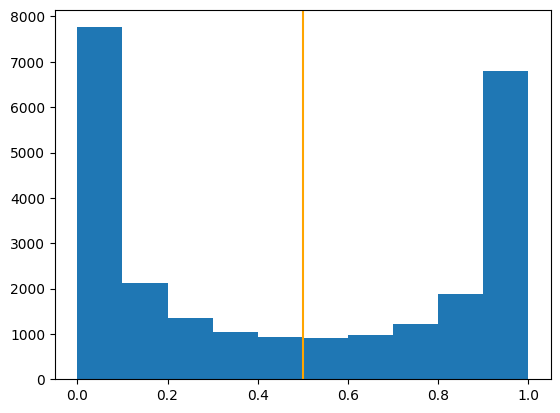

In [7]:
import matplotlib.pyplot as plt

plt.hist(rnn_model.predict(X_valid))
_ = plt.axvline(x=0.5, color="orange")